# Table of Contents<a id='TOC'></a>
# [Part 1 - Exploratory Data Analysis](#part1)
[Problem Statement](#part1_problemid) 

[Data Wrangling](#part1_datawrangling) 

[Visualization](#part1_viz) 

[Conclusions](#part1_conclusions)

# [Part 2 - Experiment and Metric Design](#part2)
# [Part 3 - Predictive Modeling](#part3)
[Problem Statement](#part3_problemid)

[Data Wrangling](#part3_datawrangling) 

[Exploratory Data Analysis](#part3_eda)

[Preprocessing](#part3_preprocessing)

[Modeling](#part3_modeling)

[Model Metrics](#part3_metrics)

[Recommendations](#part3_recommendations)

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
glob("*.json")

['logins.json', 'ultimate_data_challenge.json']

# <a id='part1'></a>Part 1 - Exploratory data analysis
[(Back to top)](#TOC)

### <a id='part1_problemid'></a> Problem Statement
[(Back to top)](#TOC)

The logins.json file contains simulated timestamps of user logins.  I will aggregate login counts in 15-minute intervals and visually explore the repeating patterns and long-term trend of the aggregated time series.

### <a id='part1_datawrangling'></a> Data Wrangling
[(Back to top)](#TOC)

In [3]:
# Part 1 - Exploratory data analysis
# Load logins.json

loginsDF = pd.read_json('logins.json')
print(loginsDF.info())
display(loginsDF.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Index should be a DatetimeIndex for time-based aggregations.

loginsDF.index = loginsDF['login_time']
print(loginsDF.info())
display(loginsDF.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB
None


,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [5]:
# Count login occurrences in each 15 minute interval

loginCounts = loginsDF.resample('15min').count()
loginCounts.columns = ['login_counts']
print(loginCounts.info())
display(loginCounts.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   login_counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB
None


,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### <a id='part1_viz'></a> Visualization
[(Back to top)](#TOC)
##### Plot count of logins per 15-minute interval over entire series

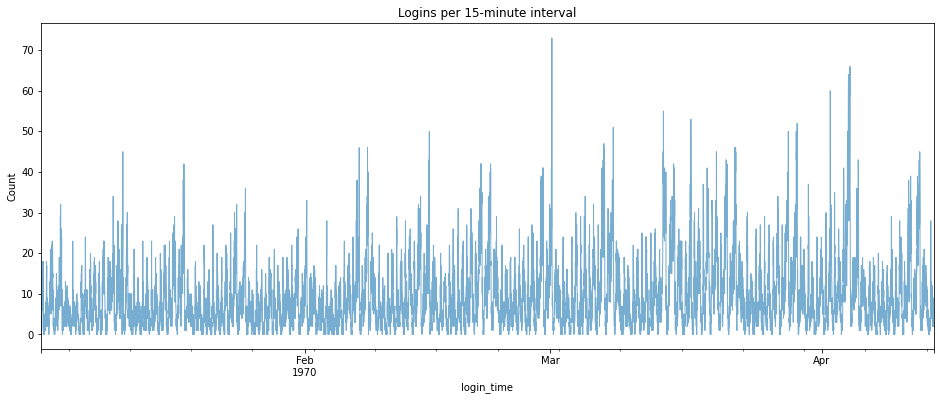

In [6]:
loginCounts.plot(figsize=(16,6), lw=1, alpha=0.6, legend=False)
plt.ylabel('Count')
plt.title('Logins per 15-minute interval')
plt.show()

#### On first glance, there seem to be daily peaks, which are higher on weekends.

In [7]:
# We want to Plot each day separately on same axis.
# Create new columns to help plot by day.

daily_logins = loginCounts.copy()
daily_logins['day_of_year'] = daily_logins.index.dayofyear
daily_logins['day_of_week'] = daily_logins.index.dayofweek
daily_logins['weekday_name'] = daily_logins['day_of_week'].map({0:"Monday",
                                                                1:"Tuesday",2:"Wednesday",3:"Thursday",
                                                               4:"Friday", 5:"Saturday", 6:"Sunday"})
daily_logins.head()

,login_counts,day_of_year,day_of_week,weekday_name
login_time,,,,
1970-01-01 20:00:00,2,1,3,Thursday
1970-01-01 20:15:00,6,1,3,Thursday
1970-01-01 20:30:00,9,1,3,Thursday
1970-01-01 20:45:00,7,1,3,Thursday
1970-01-01 21:00:00,1,1,3,Thursday


In [8]:
# See how many entries exist for each day.
daily_logins['day_of_year'].value_counts().sort_index()

1      16
2      96
3      96
4      96
5      96
       ..
99     96
100    96
101    96
102    96
103    76
Name: day_of_year, Length: 103, dtype: int64

# Visualize daily and weekly patterns.

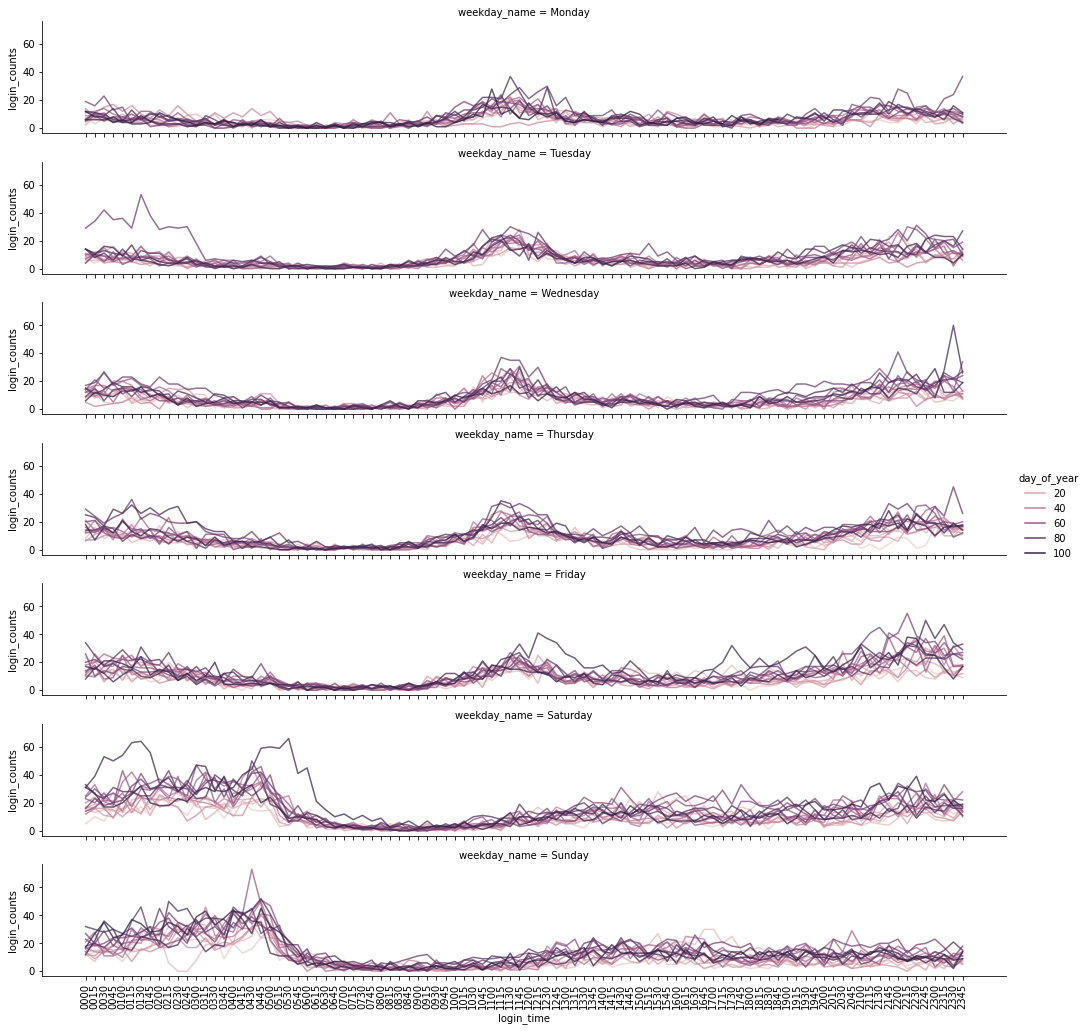

In [9]:
sns.relplot(data=daily_logins,
            x=daily_logins.index.strftime('%H%M'), 
            y='login_counts', 
            hue='day_of_year',
            row='weekday_name', row_order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
            alpha=0.75, kind='line', ci=None, height=2, aspect=7)
plt.xticks(rotation=90)
plt.show()

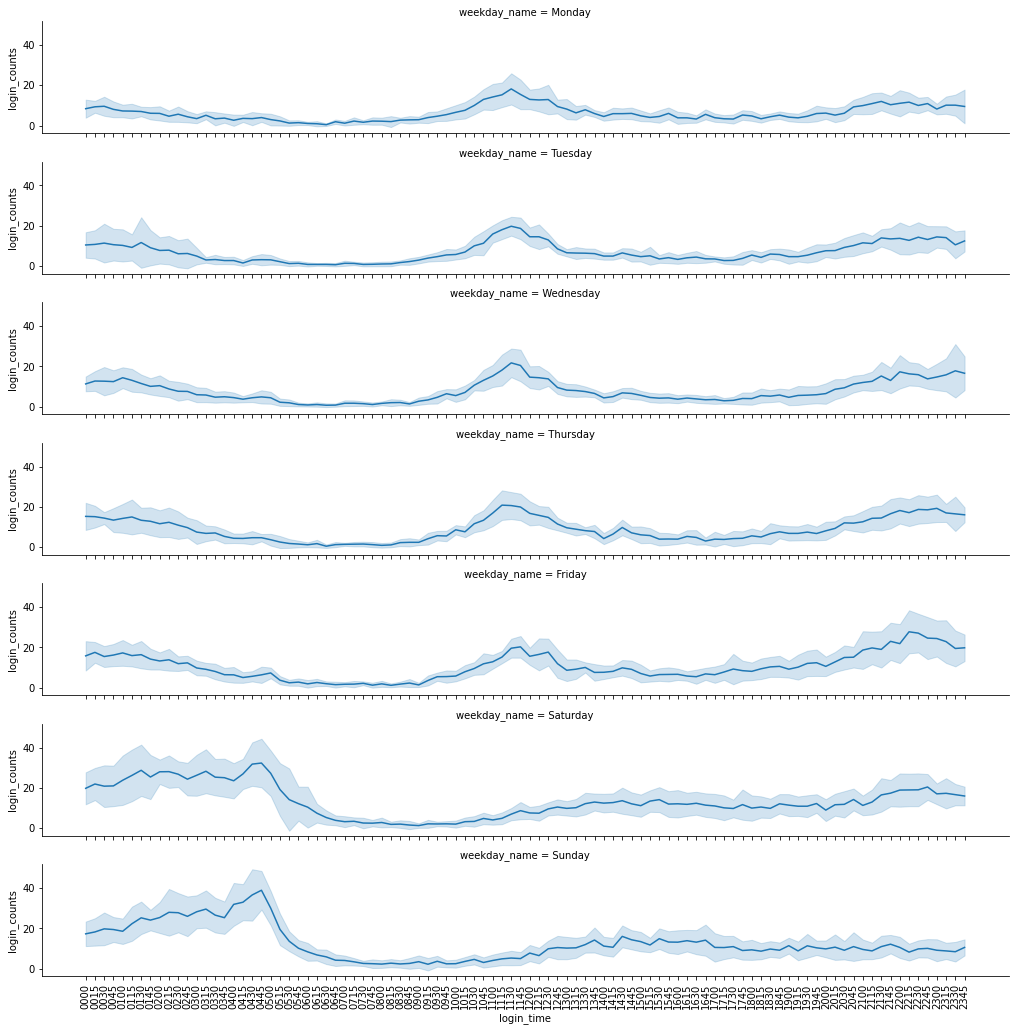

In [10]:
sns.relplot(data=daily_logins,
            x=daily_logins.index.strftime('%H%M'), 
            y='login_counts', 
            row='weekday_name', row_order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
            kind='line', estimator='mean', ci='sd', height=2, aspect=7)
plt.xticks(rotation=90)
plt.show()

# Weekly decomposition reveals trend.

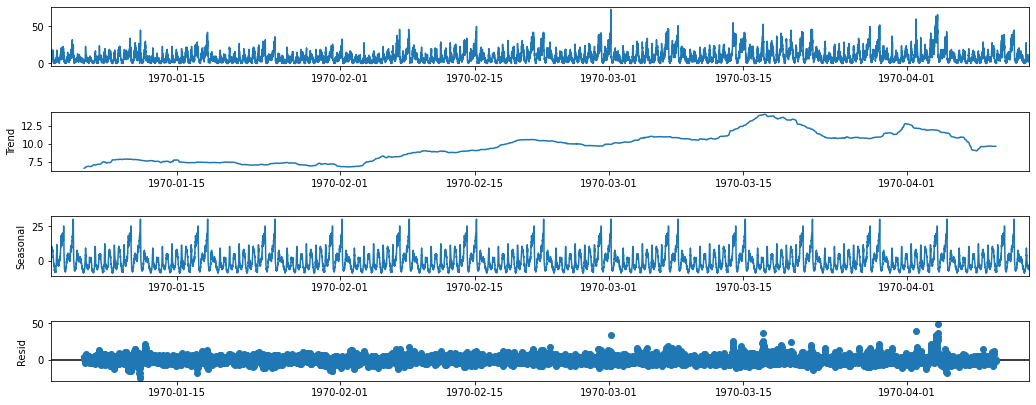

In [11]:
# Seasonal period set to 1 week (sampling period is 15 minutes, so 7*4*24 points equals 1 week)
seas_d = sm.tsa.seasonal_decompose(loginCounts, model='add', period=7*4*24)  
fig = seas_d.plot()
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

## Conclusions <a id='part1_conclusions'></a>
[(Back to top)](#TOC)

### Weekly patterns of logins
* On weekdays (Monday-Friday), elevated activity tends to occur from 10am-1pm, peaking around 11:30am. 
* In addition, there is elevated activity at night. On weeknights (Monday-Thursday), this elevated activity begins around 8pm-9pm and lasts until 2am-3am. 
* Over the weekend (Friday night/Saturday morning and Saturday night/Sunday morning), the nighttime activity begins around 8pm, peaks at 4:45am (probably after bars close), then rapidly drops to baseline by 6am-7am.

### Trend
* Long-term trend is mostly flat in January, then rises until a peak in late March, then modestly declines into April.

# <a id='part2'></a>Part 2 - Experiment and metrics design
[(Back to top)](#TOC)

This appears to be a non-coding assignment.

Given two adjacent cities (Gotham and Metropolis) with complementary circadian rhythms, with Gotham active at night and Metropolis active during the day, propose metrics and statistical tests to measure the effectiveness of a toll-reimbursement intervention to increase the tendency of driving partners to serve both cities rather than just one or the other.


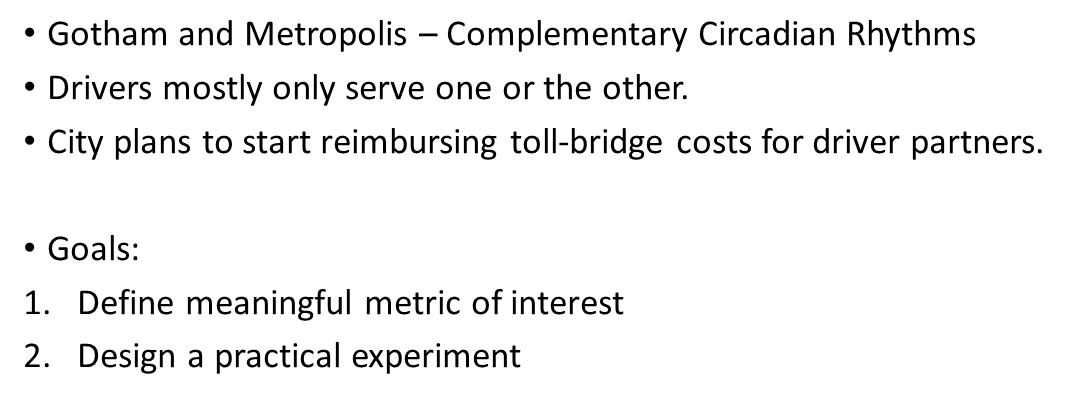

### My solution:

##### (1) Metric of Interest:

The best metric would indicate whether drivers are moving between cities to serve customers in both cities.

Success is more than just trips across the toll bridge; it also includes trips within a driver’s less preferred city.

Metric : Minimize the percent difference between trips a driver makes from a starting place in one city versus the other city.

Example: Driver Joe used to pick up 100% of his rides in Gotham and 0% in Metropolis (difference of 100%). Now he picks up 50% of his rides in Metropolis and 50% in Gotham (difference of 0%). Driver Joe is our perfect example of success.

##### (2) Practical Experiment:

(2a) If baseline data can be obtained, at least 2 weeks of data should be collected before the reimbursement program begins. Ideally there would be a phased introduction with all drivers being divided into 3 groups. The groups would gain access to reimbursement in subsequent weeks. This allows statistical testing in a cross-sectional fashion in addition to a longitudinal fashion. 

Timeline:
2 weeks without reimbursement ---> 2 weeks with only Group A reimbursed ---> 2 weeks with Groups A & B reimbursed --> 2 weeks with all Groups (A, B, & C) reimbursed.

Having staggered groups will help control for history effects that affect all groups, such as holidays. Nevertheless, the experiment should be scheduled to avoid major holidays.

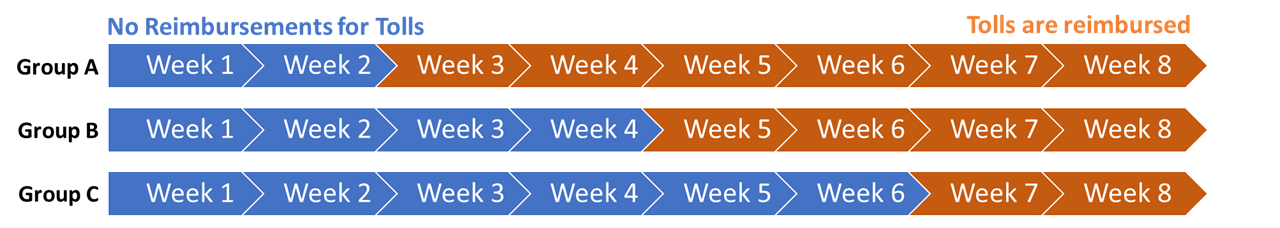

(2b) Statistics will use an ANOVA framework. Specifically, this is a 2-factor mixed-model ANOVA with 4 levels on the longitudinal time factor and 3 levels on the cross-sectional group factor. 

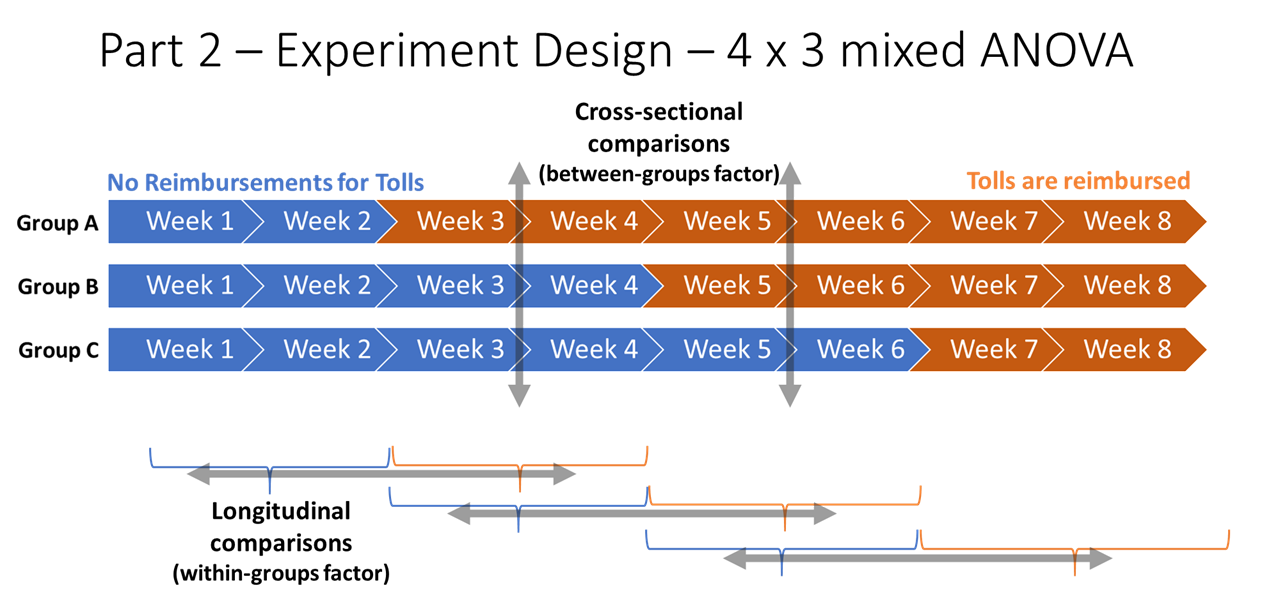

We want a p-value of less than 0.05 for:
First 2 weeks compared to final 2 weeks
Before versus after intervention for each individual group
Cross-sectional differences for the middle weeks, when some groups are reimbursed and some are not.
Interaction between time and group.

Failure to find significant p-values could indicate problems with roll-out of the reimbursement plan. 
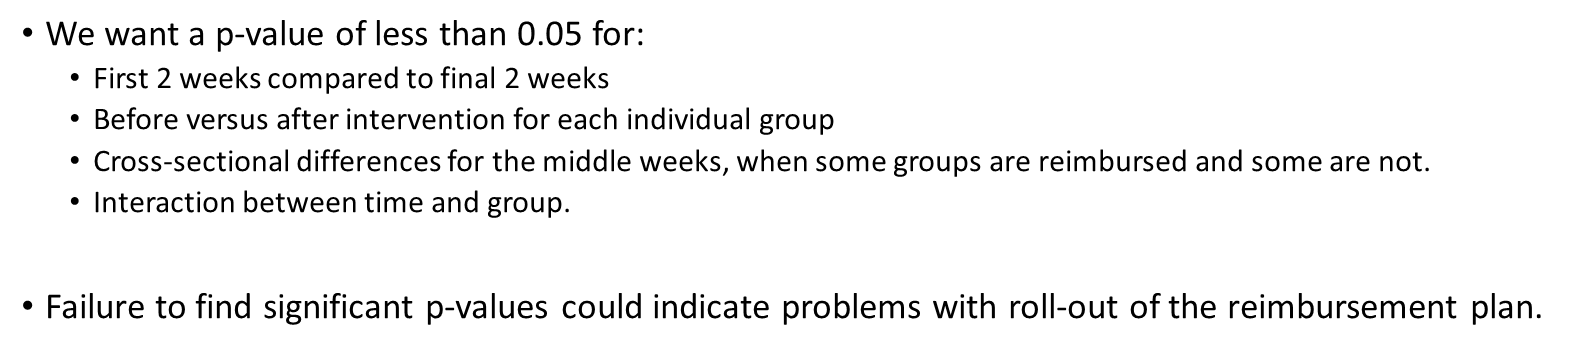

(2c) Interpretation should be simple. Statistical increases in reimbursement and inter-city rides should be obvious if the reimbursement program was advertised effectively (assuming the toll was the reason why drivers avoided crossing the bridge to begin with). Meaningful changes will probably take longer than a few weeks to be fully realized, but the correlation of the key metric with time since implementation should indicate a favorable trajectory.

The city operations team should follow the changes over time and decide whether the program is satisfying their original goal in a meaningful way. I would think the primary motivation is either increasing commerce and taxes or increasing transit options for the population. This benefit should be balanced against the cost of reimbursements.




# <a id='part3'></a>Part 3 - Predictive modeling
[(Back to top)](#TOC)

### <a id='part3_problemid'></a> Problem Statement
[(Back to top)](#TOC)

Ultimate wants to predict rider retention. Specifically, this is a binary classification problem in which users who took a trip in the last 30 days are considered active. The file ultimate_data_challenge.json contains 11 fields. Some data wrangling is necessary to extract numeric values and separate the target column. Predictive models will then show that GradientBoostingClassifier performs the best.

### <a id='part3_datawrangling'></a> Data Wrangling
[(Back to top)](#TOC)

In [12]:
glob("*.json")

['logins.json', 'ultimate_data_challenge.json']

In [13]:
# Load Data in pandas DataFrame

df = pd.read_json('ultimate_data_challenge.json')
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
# signup_date and #last_trip_date should be datetime objects instead of strings.

df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
# Inspect number of null values per column (avg_rating_of_driver may need to be dropped later due to high null values)

print('null values')
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col, ':\t',df[col].isnull().sum() , 'null values')

null values
avg_rating_of_driver :	 8122 null values
phone :	 396 null values
avg_rating_by_driver :	 201 null values


In [16]:
print(df.city.value_counts())

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


In [17]:
print(df.phone.value_counts())

iPhone     34582
Android    15022
Name: phone, dtype: int64


### Goals of predictive modeling:
* Identify predictors of user retention (defined as the last_trip_date being within the last 30 days)

Note: The "current" date is not given for tracing back 30 days from. I will assume it is the day after the last trip in the dataset. 

##### last_trip_date between 2014-06-02 and 2014-07-01 (inclusive) indicates an active user

In [18]:
df.last_trip_date.max().strftime('%Y-%m-%d')

'2014-07-01'

In [19]:
df.last_trip_date.max() + pd.to_timedelta(1, unit='d') - pd.to_timedelta(30, unit='d')

Timestamp('2014-06-02 00:00:00')

In [20]:
df.last_trip_date

0       2014-06-17
1       2014-05-05
2       2014-01-07
3       2014-06-29
4       2014-03-15
           ...    
49995   2014-06-05
49996   2014-01-25
49997   2014-05-22
49998   2014-01-15
49999   2014-04-20
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [21]:
df.last_trip_date >= (df.last_trip_date.max() + pd.to_timedelta(1, unit='d') - pd.to_timedelta(30, unit='d'))

0         True
1        False
2        False
3         True
4        False
         ...  
49995     True
49996    False
49997    False
49998    False
49999    False
Name: last_trip_date, Length: 50000, dtype: bool

In [22]:
# Create target column.
df['Active'] = df.last_trip_date >= (df.last_trip_date.max() + pd.to_timedelta(1, unit='d') - pd.to_timedelta(30, unit='d'))

In [23]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


### <a id='part3_eda'></a> Exploratory Data Analysis
[(Back to top)](#TOC)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


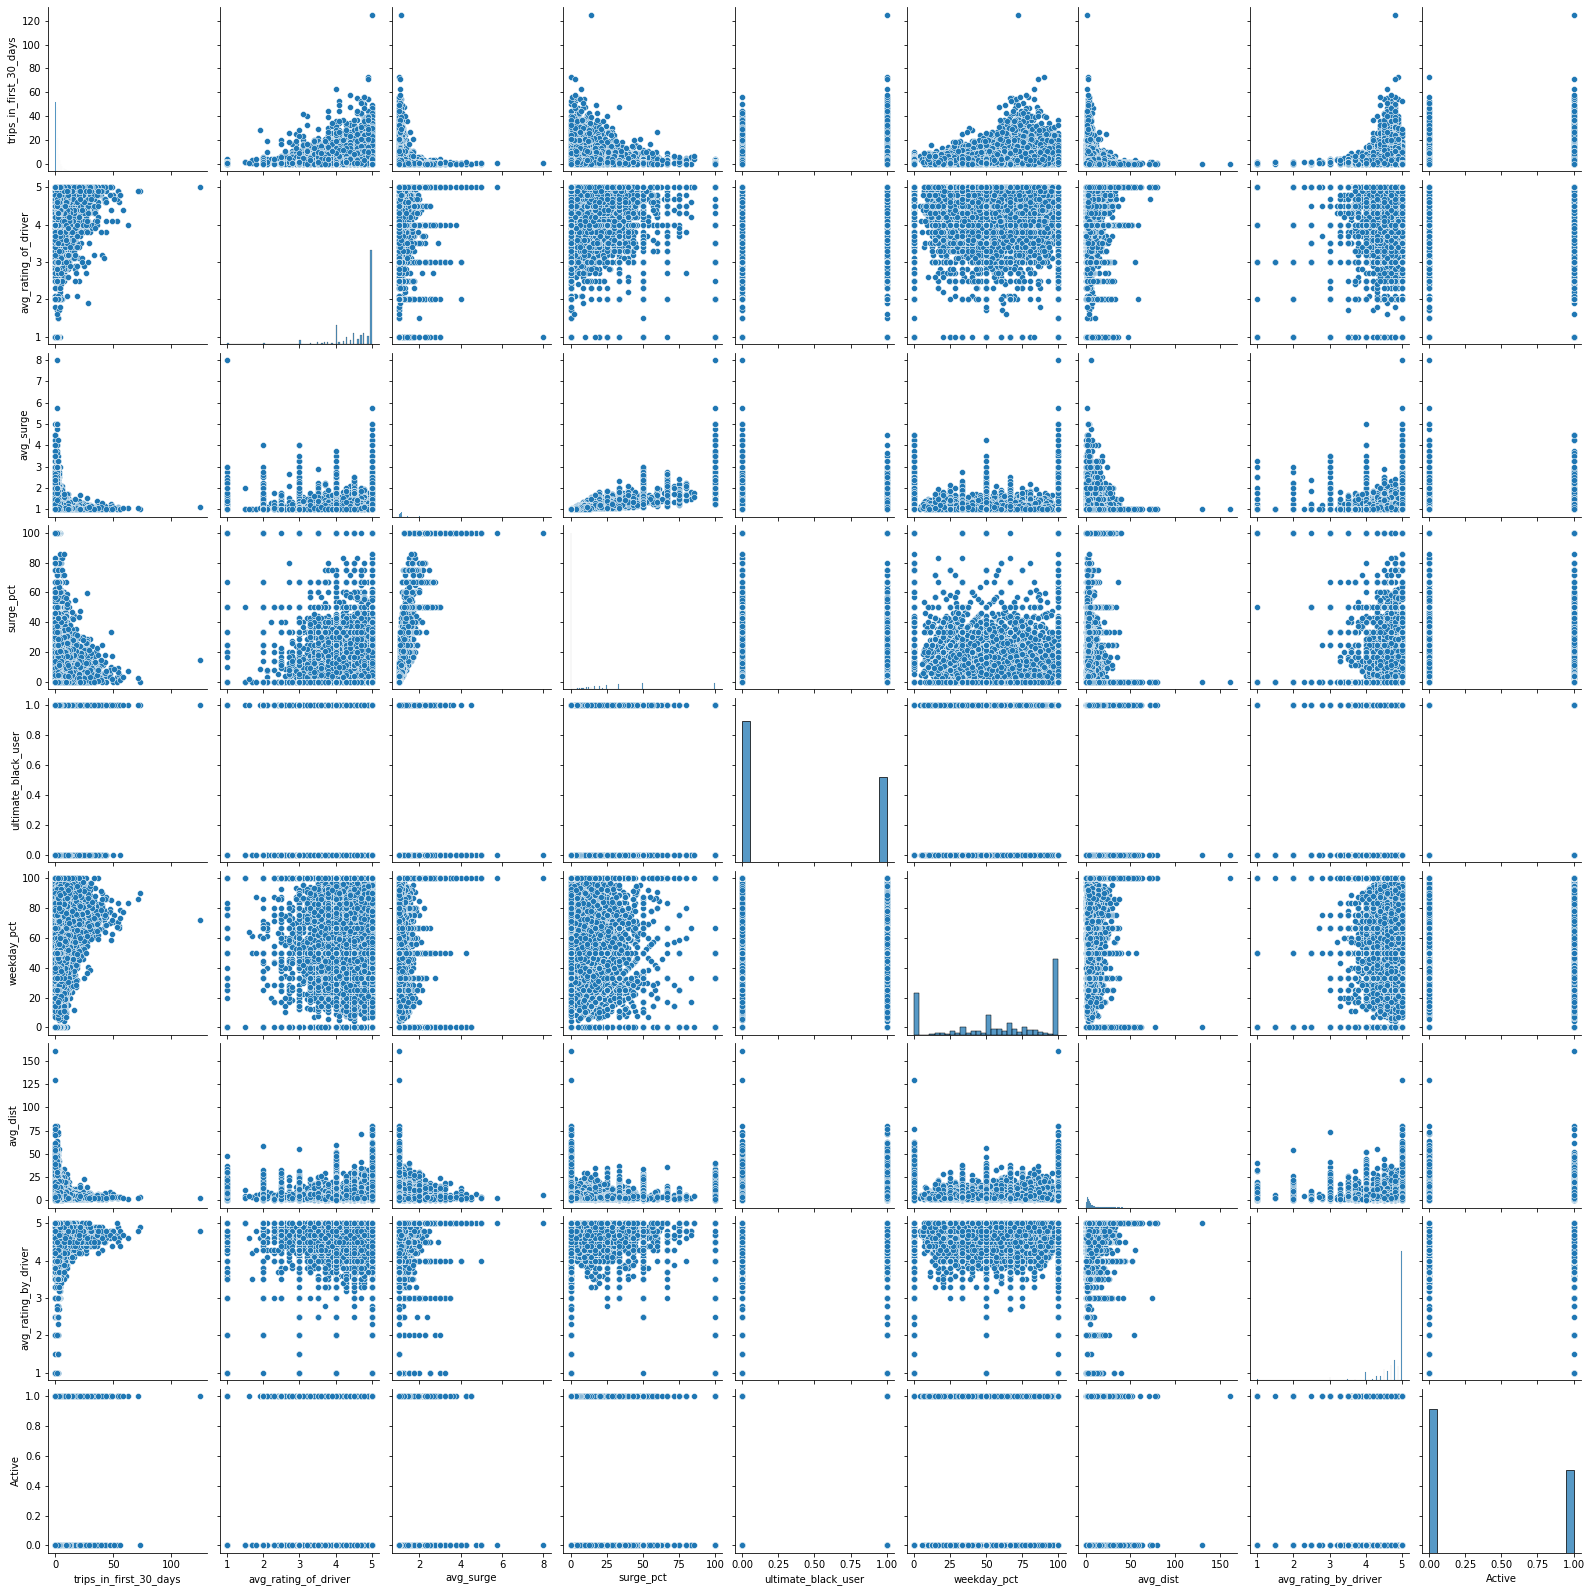

In [24]:
sns.pairplot(df)

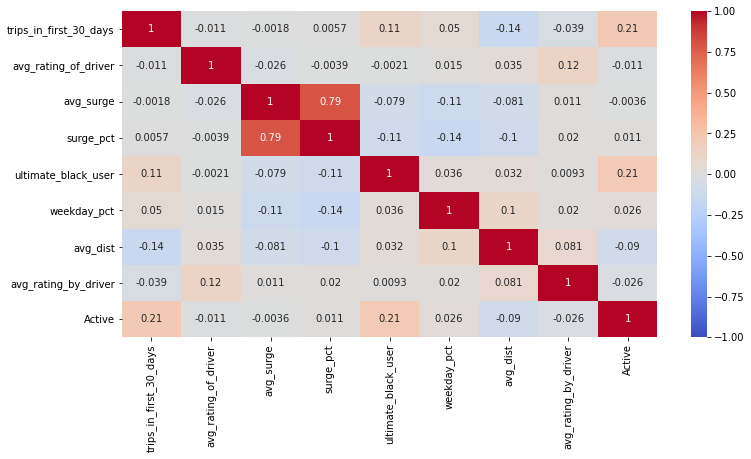

In [25]:
# There is not much correlation between variables, besides avg_surge and surge_pct

fig, ax = plt.subplots(1,1,figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
plt.show()

### <a id='part3_preprocessing'></a> Preprocessing
[(Back to top)](#TOC)

# Drop column avg_rating_of_driver because there are so many null values and there is so little correlation with target and with most other features.

In [26]:
df2 = df.drop(['avg_rating_of_driver'], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   phone                   49604 non-null  object        
 6   surge_pct               50000 non-null  float64       
 7   ultimate_black_user     50000 non-null  bool          
 8   weekday_pct             50000 non-null  float64       
 9   avg_dist                50000 non-null  float64       
 10  avg_rating_by_driver    49799 non-null  float64       
 11  Active                  50000 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(5), int

In [27]:
# One-hot encoding with pandas get_dummies

df2 = pd.concat([df2, pd.get_dummies(df2.city, drop_first=True)], axis=1)
df2 = pd.concat([df2, pd.get_dummies(df2.phone, drop_first=False)], axis=1)  # Because there are null values, don't drop first (data is not totally co-linear).
df2 = df2.drop(['city', 'phone'], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_surge               50000 non-null  float64       
 3   last_trip_date          50000 non-null  datetime64[ns]
 4   surge_pct               50000 non-null  float64       
 5   ultimate_black_user     50000 non-null  bool          
 6   weekday_pct             50000 non-null  float64       
 7   avg_dist                50000 non-null  float64       
 8   avg_rating_by_driver    49799 non-null  float64       
 9   Active                  50000 non-null  bool          
 10  King's Landing          50000 non-null  uint8         
 11  Winterfell              50000 non-null  uint8         
 12  Android                 50000 non-null  uint8 

In [28]:
df2.signup_date.min()

Timestamp('2014-01-01 00:00:00')

In [29]:
df2.signup_date.min().dayofyear

1

In [30]:
df2.signup_date.max()

Timestamp('2014-01-31 00:00:00')

In [31]:
df2.signup_date.max().dayofyear

31

In [32]:
df2['signup_date_numerical'] = df['signup_date'].dt.dayofyear
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_surge               50000 non-null  float64       
 3   last_trip_date          50000 non-null  datetime64[ns]
 4   surge_pct               50000 non-null  float64       
 5   ultimate_black_user     50000 non-null  bool          
 6   weekday_pct             50000 non-null  float64       
 7   avg_dist                50000 non-null  float64       
 8   avg_rating_by_driver    49799 non-null  float64       
 9   Active                  50000 non-null  bool          
 10  King's Landing          50000 non-null  uint8         
 11  Winterfell              50000 non-null  uint8         
 12  Android                 50000 non-null  uint8 

In [33]:
df2 = df2.drop('signup_date', axis=1)
df2.head()

,trips_in_first_30_days,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active,King's Landing,Winterfell,Android,iPhone,signup_date_numerical
0,4,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,True,1,0,0,1,25
1,0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,False,0,0,1,0,29
2,3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,False,0,0,0,1,6
3,9,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,True,1,0,0,1,10
4,14,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,0,1,1,0,27


In [34]:
df2 = df2.drop('last_trip_date', axis=1)
df2.head()

,trips_in_first_30_days,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active,King's Landing,Winterfell,Android,iPhone,signup_date_numerical
0,4,1.10,15.4,True,46.2,3.67,5.0,True,1,0,0,1,25
1,0,1.00,0.0,False,50.0,8.26,5.0,False,0,0,1,0,29
2,3,1.00,0.0,False,100.0,0.77,5.0,False,0,0,0,1,6
3,9,1.14,20.0,True,80.0,2.36,4.9,True,1,0,0,1,10
4,14,1.19,11.8,False,82.4,3.13,4.9,False,0,1,1,0,27


In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_surge               50000 non-null  float64
 2   surge_pct               50000 non-null  float64
 3   ultimate_black_user     50000 non-null  bool   
 4   weekday_pct             50000 non-null  float64
 5   avg_dist                50000 non-null  float64
 6   avg_rating_by_driver    49799 non-null  float64
 7   Active                  50000 non-null  bool   
 8   King's Landing          50000 non-null  uint8  
 9   Winterfell              50000 non-null  uint8  
 10  Android                 50000 non-null  uint8  
 11  iPhone                  50000 non-null  uint8  
 12  signup_date_numerical   50000 non-null  int64  
dtypes: bool(2), float64(5), int64(2), uint8(4)
memory usage: 3.0 MB


# Check histogram of avg_rating_by_driver. Consider imputing mean or median.

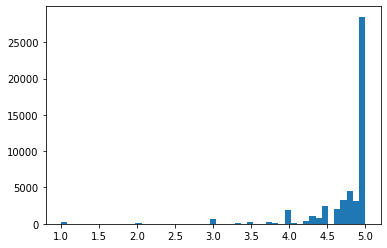

In [36]:
plt.hist(df2.avg_rating_by_driver, bins=49)
plt.show()

In [37]:
print(df2.avg_rating_by_driver.mean())
print(df2.avg_rating_by_driver.median())

4.77815819594771
5.0


In [38]:
# impute mean
df2.avg_rating_by_driver.fillna(df2.avg_rating_by_driver.mean(), axis=0, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_surge               50000 non-null  float64
 2   surge_pct               50000 non-null  float64
 3   ultimate_black_user     50000 non-null  bool   
 4   weekday_pct             50000 non-null  float64
 5   avg_dist                50000 non-null  float64
 6   avg_rating_by_driver    50000 non-null  float64
 7   Active                  50000 non-null  bool   
 8   King's Landing          50000 non-null  uint8  
 9   Winterfell              50000 non-null  uint8  
 10  Android                 50000 non-null  uint8  
 11  iPhone                  50000 non-null  uint8  
 12  signup_date_numerical   50000 non-null  int64  
dtypes: bool(2), float64(5), int64(2), uint8(4)
memory usage: 3.0 MB


# Separate target column (Active) and the column it was based on (last_trip_date)

In [39]:
y = df2.Active
print(y.head())

0     True
1    False
2    False
3     True
4    False
Name: Active, dtype: bool


In [40]:
y.value_counts()

False    31690
True     18310
Name: Active, dtype: int64

In [41]:
y.value_counts()/y.count()

False    0.6338
True     0.3662
Name: Active, dtype: float64

### 36.62% of observed users were retained.

### <a id='part3_modeling'></a> Modeling
[(Back to top)](#TOC)

In [42]:
X = df2[["trips_in_first_30_days", "avg_surge", "surge_pct", "ultimate_black_user", "weekday_pct", "avg_dist", 
        "avg_rating_by_driver", "King's Landing", "Winterfell", "Android", "iPhone", "signup_date_numerical"]]
print(X.head())

   trips_in_first_30_days  avg_surge  surge_pct  ultimate_black_user  \
0                       4       1.10       15.4                 True   
1                       0       1.00        0.0                False   
2                       3       1.00        0.0                False   
3                       9       1.14       20.0                 True   
4                      14       1.19       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  King's Landing  Winterfell  \
0         46.2      3.67                   5.0               1           0   
1         50.0      8.26                   5.0               0           0   
2        100.0      0.77                   5.0               0           0   
3         80.0      2.36                   4.9               1           0   
4         82.4      3.13                   4.9               0           1   

   Android  iPhone  signup_date_numerical  
0        0       1                     25  
1        1

# Classification models

First models to test include LogisticRegression, SupportVectorClassifier (SVC), and RandomForestClassifier

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
steps_lr = [('scaler', StandardScaler()),('pca', PCA()),('est', LogisticRegression())]
steps_svc = [('scaler', StandardScaler()), ('nystroem', Nystroem()), ('est', SGDClassifier())]
steps_rf = [('est', RandomForestClassifier())]

pipeline_lr = Pipeline(steps_lr)
pipeline_svc = Pipeline(steps_svc)
pipeline_rf = Pipeline(steps_rf)

In [46]:
params_lr = {'est__C':[0.01, 0.1, 1, 10], 'pca__n_components':[None,2, 4, 10]}
params_svc = {'nystroem__n_components':[100, 500, 1000, 2000]}
params_rf = {'est__n_estimators':[4,9,16,25,36, 49,64,81,100,250, 500,1000]}

In [47]:
for pipe, params, name in zip([pipeline_lr, pipeline_svc, pipeline_rf],
                             [params_lr, params_svc, params_rf],
                             ["LogisticRegression", "SVC", "RandomForest"]):
    gs_cv = GridSearchCV(pipe, params, cv=5, scoring='roc_auc')
    gs_cv.fit(X_train, y_train)
    print(name)
    print("gs_cv.best_params_",gs_cv.best_params_)
    print("gs_cv.best_score_",gs_cv.best_score_)
    print(gs_cv.cv_results_)
    print('\n')

LogisticRegression
gs_cv.best_params_ {'est__C': 0.1, 'pca__n_components': None}
gs_cv.best_score_ 0.7682161063721212
{'mean_fit_time': array([0.19643264, 0.22047181, 0.19501424, 0.19481544, 0.18021517,
       0.24881811, 0.1742137 , 0.13261003, 0.1848156 , 0.23021846,
       0.19701486, 0.16461306, 0.20341692, 0.25842023, 0.25822005,
       0.17521439]), 'std_fit_time': array([0.03524477, 0.02828283, 0.02474919, 0.02855075, 0.02840941,
       0.03375118, 0.03496169, 0.01938809, 0.05725027, 0.03502539,
       0.01971059, 0.01184405, 0.04228608, 0.01146579, 0.02114281,
       0.03690924]), 'mean_score_time': array([0.02376122, 0.01874642, 0.01840181, 0.0236011 , 0.0176002 ,
       0.02220144, 0.01380005, 0.0134006 , 0.01980019, 0.01779981,
       0.0139998 , 0.0190002 , 0.02160063, 0.02580094, 0.02020106,
       0.01740055]), 'std_score_time': array([0.00425051, 0.00681294, 0.00581754, 0.00349816, 0.00634398,
       0.00426202, 0.00116665, 0.00149652, 0.00639965, 0.00386678,
       0.00

# Based on these initial options, I would choose RandomForestClassifier with default n_estimators=100.  This is for a balance of low fit time with near-maximal performance.

In [48]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))

accuracy: 0.7729


# For comparison, run the other best models above, then try ExtraTreesClassifier and GradientBoostingClassifier.

LogisticRegression
accuracy: 0.722


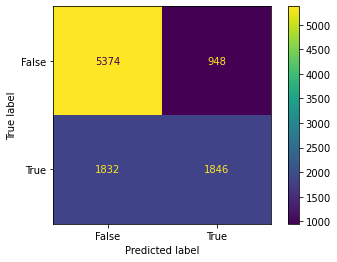

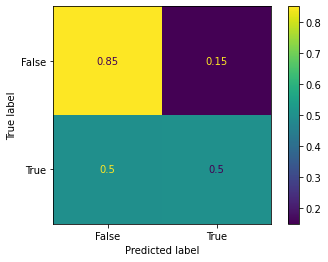



SVC
accuracy: 0.769


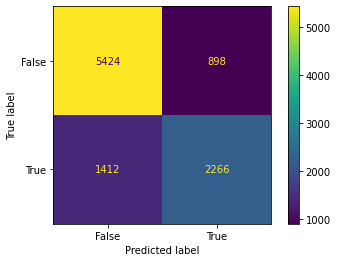

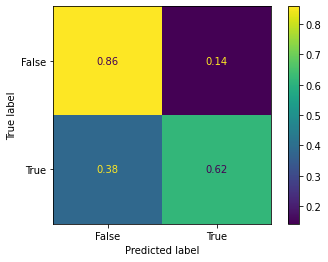



RandomForest
accuracy: 0.7748


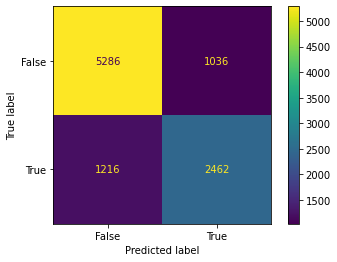

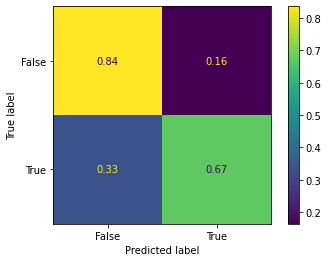

In [49]:
steps_lr_test = [('scaler', StandardScaler()),('pca', PCA(n_components=None)),('est', LogisticRegression(C=0.1))]
steps_svc_test = [('scaler', StandardScaler()), ('nystroem', Nystroem(n_components=2000)), ('est', SGDClassifier())]
steps_rf_test = [('est', RandomForestClassifier(n_estimators=1000))]

pipeline_lr_test = Pipeline(steps_lr_test)
pipeline_svc_test = Pipeline(steps_svc_test)
pipeline_rf_test = Pipeline(steps_rf_test)

for pipe, name in zip([pipeline_lr_test, pipeline_svc_test, pipeline_rf_test],
                             ["LogisticRegression", "SVC", "RandomForest"]):
    
    pipe.fit(X_train, y_train)
    print(name)
    predictions = pipe.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(pipe, X_test, y_test)
    plt.show()
    plot_confusion_matrix(pipe, X_test, y_test, normalize='true')
    plt.show()
    print('\n')

LogisticRegression
accuracy: 0.722


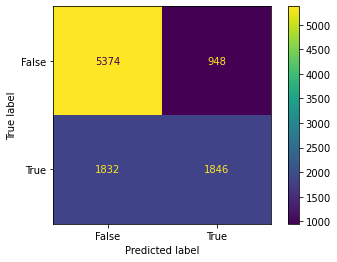

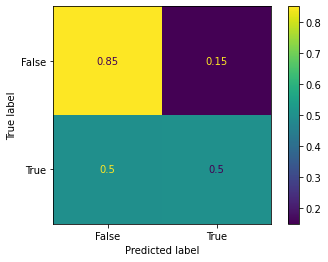



SVC
accuracy: 0.7679


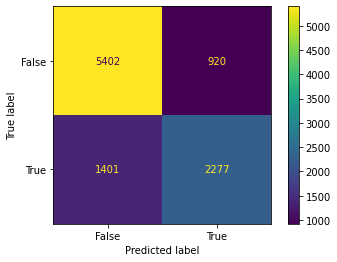

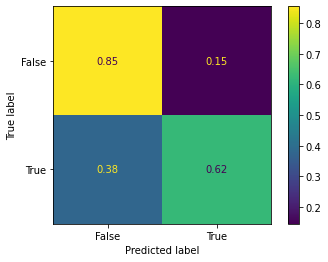



RandomForest
accuracy: 0.7752


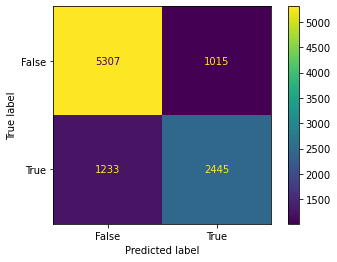

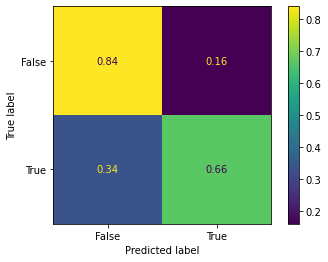



ExtraTrees
accuracy: 0.7658


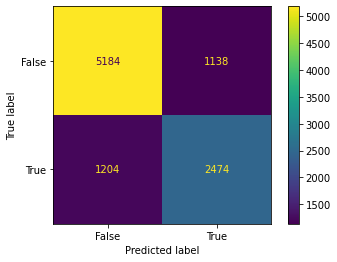

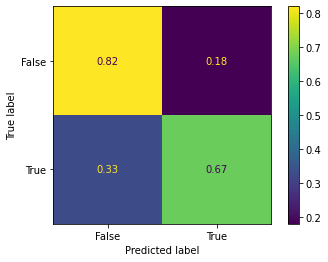



GradientBoostingClassifier
accuracy: 0.791


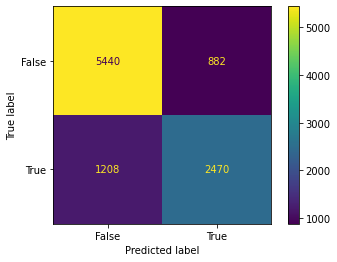

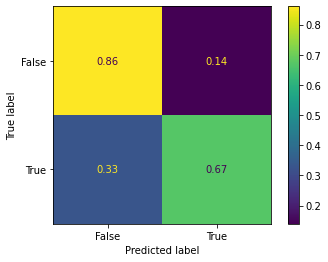

In [50]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

steps_lr_test = [('scaler', StandardScaler()),('pca', PCA(n_components=None)),('est', LogisticRegression(C=0.1))]
steps_svc_test = [('scaler', StandardScaler()), ('nystroem', Nystroem(n_components=500)), ('est', SGDClassifier())]
steps_rf_test = [('est', RandomForestClassifier(n_estimators=100))]


pipeline_lr_test = Pipeline(steps_lr_test)
pipeline_svc_test = Pipeline(steps_svc_test)
pipeline_rf_test = Pipeline(steps_rf_test)

for pipe, name in zip([pipeline_lr_test, pipeline_svc_test, pipeline_rf_test, ExtraTreesClassifier(), 
                      GradientBoostingClassifier()],
                             ["LogisticRegression", "SVC", "RandomForest","ExtraTrees","GradientBoostingClassifier"]):
    
    pipe.fit(X_train, y_train)
    print(name)
    predictions = pipe.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(pipe, X_test, y_test)
    plt.show()
    plot_confusion_matrix(pipe, X_test, y_test, normalize='true')
    plt.show()
    print('\n')

In [66]:
name='ExtraTreesClassifier'
gs = GridSearchCV(ExtraTreesClassifier(), {'n_estimators':[100]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

ExtraTreesClassifier
gs.best_params_ {'n_estimators': 100}
gs.best_score_ 0.8208872250279702
{'mean_fit_time': array([5.24470458]), 'std_fit_time': array([0.53316062]), 'mean_score_time': array([0.46374292]), 'std_score_time': array([0.09583067]), 'param_n_estimators': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}], 'split0_test_score': array([0.81800969]), 'split1_test_score': array([0.82920756]), 'split2_test_score': array([0.81676165]), 'split3_test_score': array([0.82463451]), 'split4_test_score': array([0.81582271]), 'mean_test_score': array([0.82088723]), 'std_test_score': array([0.00518112]), 'rank_test_score': array([1])}




In [51]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['deviance','exponential'], 
                                           'n_estimators':[64,100,144,196,256]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'deviance', 'n_estimators': 256}
gs.best_score_ 0.8576313181023811
{'mean_fit_time': array([ 3.17823877,  4.17751656,  6.19585443,  8.84964614, 10.44838572,
        2.36958117,  3.75088549,  5.526617  ,  7.22474413,  9.21829419]), 'std_fit_time': array([0.26699263, 0.34714161, 0.45500425, 0.58351376, 0.95150669,
       0.22208376, 0.1937165 , 0.09164346, 0.28362624, 0.49601833]), 'mean_score_time': array([0.02540174, 0.03260002, 0.05500512, 0.0426024 , 0.04560289,
       0.02719817, 0.03539948, 0.02920003, 0.03680162, 0.03800087]), 'std_score_time': array([9.31039881e-03, 1.03067355e-02, 1.51816841e-02, 1.77054503e-02,
       1.47053519e-02, 1.10349725e-02, 1.36940287e-02, 1.47085274e-03,
       5.45587384e-03, 2.33309361e-06]), 'param_loss': masked_array(data=['deviance', 'deviance', 'deviance', 'deviance',
                   'deviance', 'exponential', 'exponential',
                   'exponential', 'exponential', 'exponential'],
  

GradientBoostingClassifier
accuracy: 0.7966


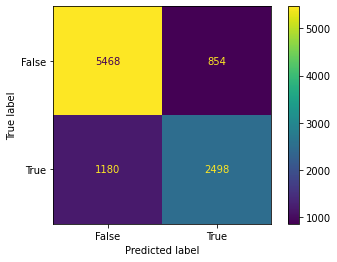

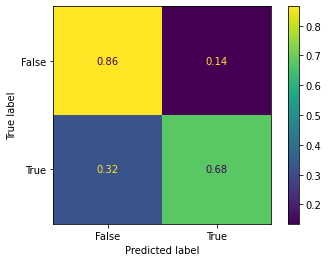

In [52]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

In [53]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[64,100,144,196,256,512]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 512}
gs.best_score_ 0.8582230305447439
{'mean_fit_time': array([ 2.55959373,  3.94529729,  5.31870117,  7.23774443,  9.53631806,
       18.49739094]), 'std_fit_time': array([0.0821494 , 0.11528292, 0.28782077, 0.34191242, 0.25944853,
       0.26991619]), 'mean_score_time': array([0.02900052, 0.03400192, 0.02920132, 0.0386014 , 0.04620204,
       0.06780381]), 'std_score_time': array([0.01025332, 0.00767123, 0.00146912, 0.00496441, 0.01463527,
       0.01284561]), 'param_loss': masked_array(data=['exponential', 'exponential', 'exponential',
                   'exponential', 'exponential', 'exponential'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[64, 100, 144, 196, 256, 512],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [

GradientBoostingClassifier
accuracy: 0.7959


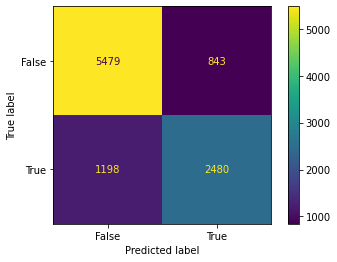

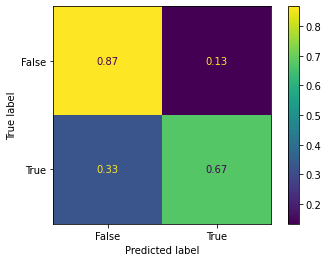

In [54]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

In [55]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[512],
                                                'subsample':[0.5, 0.75, 1.0]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 512, 'subsample': 0.75}
gs.best_score_ 0.8586683948857052
{'mean_fit_time': array([13.07938738, 17.14328871, 18.51889267]), 'std_fit_time': array([0.49296338, 0.35609599, 0.53175028]), 'mean_score_time': array([0.06760092, 0.0646049 , 0.0608047 ]), 'std_score_time': array([0.00549445, 0.00436415, 0.0045352 ]), 'param_loss': masked_array(data=['exponential', 'exponential', 'exponential'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[512, 512, 512],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.5, 0.75, 1.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'loss': 'exponential', 'n_estimators': 512, 'subsample': 0.5}, {'loss': 'exponential', 'n_estimators': 512, 'subsample': 0.75}, {

GradientBoostingClassifier
accuracy: 0.797


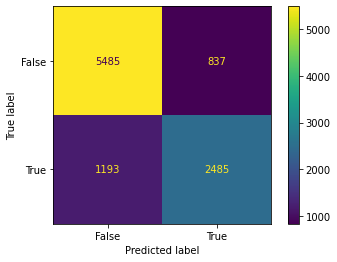

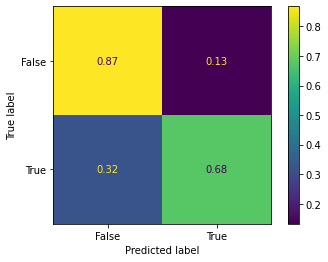

In [56]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

In [57]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[256],
                                                'subsample':[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 256, 'subsample': 0.75}
gs.best_score_ 0.8577939270365251
{'mean_fit_time': array([6.60290346, 7.09253235, 7.15833511, 7.45535998, 7.75578232,
       7.99080148, 8.69305277, 9.22209382, 9.3647037 , 9.63052683,
       9.73553481]), 'std_fit_time': array([0.4458287 , 0.52811129, 0.24023187, 0.31463763, 0.10444059,
       0.31759653, 0.13187827, 0.3978532 , 0.47778512, 0.07174134,
       0.37070837]), 'mean_score_time': array([0.04560275, 0.05080328, 0.04160547, 0.04020267, 0.03980298,
       0.05440335, 0.04800324, 0.04080153, 0.04420276, 0.04959974,
       0.05820203]), 'std_score_time': array([0.00659006, 0.02221584, 0.00377465, 0.00172077, 0.00172149,
       0.01902403, 0.0118842 , 0.002041  , 0.00470795, 0.01167661,
       0.01942836]), 'param_loss': masked_array(data=['exponential', 'exponential', 'exponential',
                   'exponential', 'exponential', 'exponential',
                   'expone

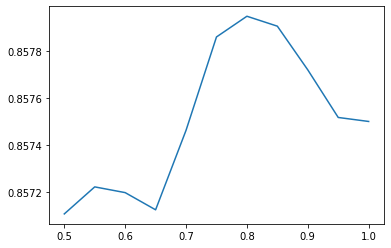

In [58]:
plt.plot( [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], np.array([0.85710811, 0.85722295, 0.8571986 , 0.85712557, 0.8574633 ,
       0.85785992, 0.85794794, 0.85790574, 0.85772013, 0.8575179 ,
       0.8575009 ]))

GradientBoostingClassifier
accuracy: 0.7976


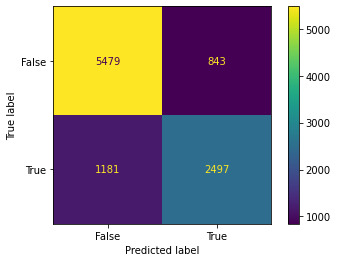

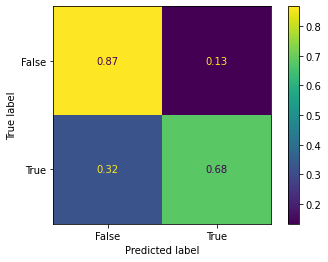

In [59]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

In [60]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[1000],
                                                'subsample':[0.8]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 1000, 'subsample': 0.8}
gs.best_score_ 0.8580308445897578
{'mean_fit_time': array([33.88614845]), 'std_fit_time': array([0.77509168]), 'mean_score_time': array([0.13940802]), 'std_score_time': array([0.03107962]), 'param_loss': masked_array(data=['exponential'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'loss': 'exponential', 'n_estimators': 1000, 'subsample': 0.8}], 'split0_test_score': array([0.85529876]), 'split1_test_score': array([0.86337317]), 'split2_test_score': array([0.85263493]), 'split3_test_score': array([0.86417761]), 'split4_test_score': array([0.85466975]), 'mean_test_score': array([0.85803084]), 'std

GradientBoostingClassifier
accuracy: 0.7954


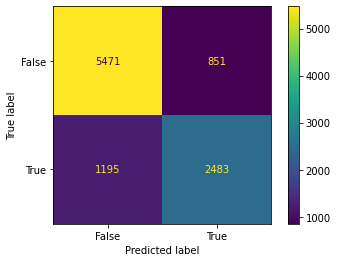

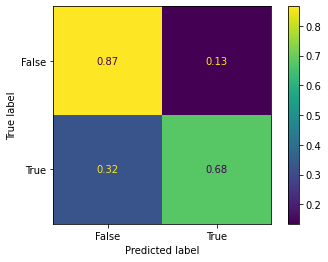

In [61]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

In [62]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[256],
                                                'subsample':[0.8]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 256, 'subsample': 0.8}
gs.best_score_ 0.8578954908839265
{'mean_fit_time': array([8.19401422]), 'std_fit_time': array([0.4110528]), 'mean_score_time': array([0.03940406]), 'std_score_time': array([0.0028709]), 'param_loss': masked_array(data=['exponential'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[256],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'loss': 'exponential', 'n_estimators': 256, 'subsample': 0.8}], 'split0_test_score': array([0.85577001]), 'split1_test_score': array([0.86459979]), 'split2_test_score': array([0.8511172]), 'split3_test_score': array([0.8637369]), 'split4_test_score': array([0.85425356]), 'mean_test_score': array([0.85789549]), 'std_test_sc

GradientBoostingClassifier
accuracy: 0.7966


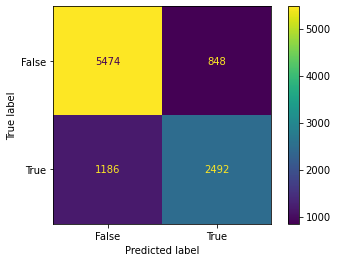

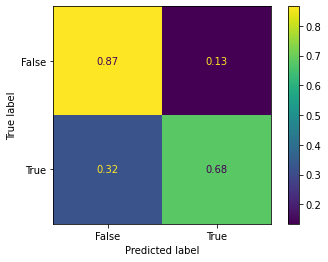

In [63]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

In [64]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[64,128,192,256,320],
                                                'subsample':[0.8]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 320, 'subsample': 0.8}
gs.best_score_ 0.8582664801031896
{'mean_fit_time': array([ 2.1839633 ,  4.03450813,  5.93784642,  8.27582235, 10.30117469]), 'std_fit_time': array([0.21354163, 0.14144923, 0.3872102 , 0.34604252, 0.21307937]), 'mean_score_time': array([0.02040167, 0.02699742, 0.03420272, 0.04720364, 0.04480309]), 'std_score_time': array([4.89726280e-04, 8.78286930e-06, 1.93886356e-03, 1.74070499e-02,
       2.63856204e-03]), 'param_loss': masked_array(data=['exponential', 'exponential', 'exponential',
                   'exponential', 'exponential'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[64, 128, 192, 256, 320],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8, 0.8, 0.8, 0.8, 0.8],
             

In [67]:
name='GradientBoostingClassifier'
gs = GridSearchCV(GradientBoostingClassifier(), {'loss':['exponential'], 
                                           'n_estimators':[320],
                                                'subsample':[0.8]}, cv=5, scoring='roc_auc')
gs.fit(X_train, y_train)
print(name)
print("gs.best_params_", gs.best_params_)
print("gs.best_score_", gs.best_score_)
print(gs.cv_results_)
print('\n')

GradientBoostingClassifier
gs.best_params_ {'loss': 'exponential', 'n_estimators': 320, 'subsample': 0.8}
gs.best_score_ 0.8583281128773865
{'mean_fit_time': array([12.76625748]), 'std_fit_time': array([0.9903677]), 'mean_score_time': array([0.06280479]), 'std_score_time': array([0.01790427]), 'param_loss': masked_array(data=['exponential'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[320],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'loss': 'exponential', 'n_estimators': 320, 'subsample': 0.8}], 'split0_test_score': array([0.85612067]), 'split1_test_score': array([0.86442513]), 'split2_test_score': array([0.85155054]), 'split3_test_score': array([0.86434123]), 'split4_test_score': array([0.855203]), 'mean_test_score': array([0.85832811]), 'std_test_

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

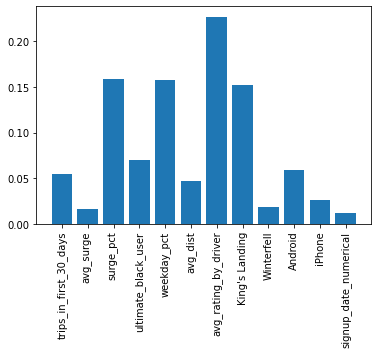

In [71]:
#gs.best_estimator_.fit(X_train, y_train)

plt.bar(x=["trips_in_first_30_days", "avg_surge", "surge_pct", "ultimate_black_user", "weekday_pct", "avg_dist", 
        "avg_rating_by_driver", "King's Landing", "Winterfell", "Android", "iPhone", "signup_date_numerical"], 
        height=gs.best_estimator_.feature_importances_)

plt.xticks(rotation=90)

GradientBoostingClassifier
accuracy: 0.7982


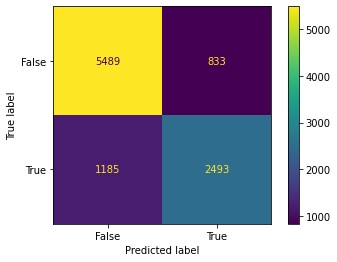

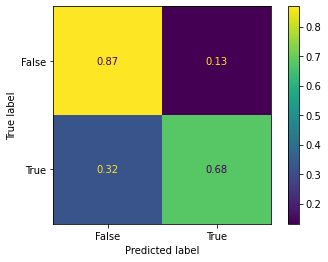

In [69]:
gs.best_estimator_.fit(X_train, y_train)
print("GradientBoostingClassifier")
predictions = gs.best_estimator_.predict(X_test)
print('accuracy:', np.mean(predictions==y_test))
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
plt.show()
plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
plt.show()
print('\n')

### <a id='part3_metrics'></a> Model Metrics
[(Back to top)](#TOC)

# The confusion matrices reveal GradientBoostingClassifier(n_estimators=320) to be the best at predicting non-active users (87% within-class accuracy) and active users (68% within-class accuracy).

| Model  | Pipeline Steps  | Best parameters  | Best ROC_AUC  | Best Accuracy  |
|---|---|---|---|---|
| GradientBoostingClassifier  | ('est', GradientBoostingClassifier())  | est__n_estimators: 320, subsample:0.8, loss:'exponential'  | 0.8583  |  0.7982 |
| RandomForestClassifier  | ('est', RandomForestClassifier())  | est__n_estimators: 1000  |  0.8349 |  0.7748 |
| SupportVectorClassifier  | ('scaler', StandardScaler()), ('nystroem', Nystroem()), ('est', SGDClassifier())  | nystroem__n_components: 2000  |  0.8266 |  0.769 |
| ExtraTreesClassifier  | ('est', ExtraTreesClassifier())  | est__n_estimators: 100  | 0.8209  | 0.7658  |
| LogisticRegression  | ('scaler', StandardScaler()), ('pca', PCA()), ('est', LogisticRegression())  | est__C: 0.1, pca__n_components: None  | 0.7682  | 0.722  |

### <a id='part3_recommendations'></a> Recommendations
[(Back to top)](#TOC)

Ultimate should use the Gradient Boosting Classifier to more efficiently target retention efforts towards those less likely to stay active. 

Feature importances showed that average rating by driver was the most important feature, a finding not visible from a simple bivariate correlation. 

The surge_pct and weekday_pct were also important. 

King's Landing had higher feature importance than Winterfell, perhaps suggesting unique characteristics of customers in King's Landing.

For marketing and retention purposes, Ultimate should consider customer segmentation based on weekday and rush hour customers, as well as King's Landing customers.